# Homework 6-2: Correlated polling errors in 2016

In this homework you will develop a slightly higher fidelity simulation of the correlated polling errors in the 2016 election. Instead of saying that the polling error for all states is identical, we'll do something closer to reality: the midwest will move as a block.


In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Part 0: The Setup
Loads the data, copied from your class notebook

In [2]:
# Load a CSV of electoral college votes for each state. 
# Ref: https://www.archives.gov/federal-register/electoral-college/allocation.html
states = pd.read_csv('data/states.csv')
states.head()

,name,abbr,electoral_votes
0,Alabama,AL,9
1,Alaska,AK,3
2,Arizona,AZ,11
3,Arkansas,AR,6
4,California,CA,55


In [3]:
# We'll use a little Pandas trick to make merging in the poll data easier: 
# set the index to the abbreviation
states = states.set_index(states.abbr)

# And add the columns we'll need: Trump, Clinton, margin_of_error, all initially blank
states['Trump'] = np.nan
states['Clinton'] = np.nan
states['margin_of_error'] = np.nan

states.head()

,name,abbr,electoral_votes,Trump,Clinton,margin_of_error
abbr,,,,,,
AL,Alabama,AL,9,NaN,NaN,NaN
AK,Alaska,AK,3,NaN,NaN,NaN
AZ,Arizona,AZ,11,NaN,NaN,NaN
AR,Arkansas,AR,6,NaN,NaN,NaN
CA,California,CA,55,NaN,NaN,NaN


In [4]:
# Not all polls have reported margins of error, but we can figure it out if we know the number of people surveyed.
# This function salculate the 95% margin of error, using the classic formula. 
# Ref: https://onlinecourses.science.psu.edu/stat100/node/56/
def calc_moe(sample_size, proportion):
    return 100 * 1.96 * math.sqrt((proportion*(1-proportion)/sample_size))

In [5]:
# Now we'll load polls for each state and pick one poll
for abbr in states.abbr: 
    polls = pd.read_csv('data/' + abbr + '.tsv', sep='\t')
    polls = polls[polls.sample_subpopulation == 'Likely Voters']
    poll = polls.tail(1).squeeze() 

    states.loc[abbr,'Trump'] = poll.Trump
    states.loc[abbr,'Clinton'] = poll.Clinton

    # There may be no MOE reported for this poll. If not, calculate it
    moe = poll.margin_of_error
    if pd.isnull(moe):
        proportion = poll.Trump / 100  # or Clinton, will give nearly same result 
        moe = calc_moe(poll.observations, proportion)

    states.loc[abbr,'margin_of_error'] = moe

In [6]:
# Helper function to interpret results
def plot_results(results):
    plt.hist(results, bins=range(150, 500, 10), density=True)
    plt.axvline(270, color='black', linestyle='dashed');
    print("Clinton win probability: " + str((results>=270).mean()))

## Part 1: The correlated Midwest


This is the function we developed in class that simulates an election where all polling errors for all states are identical.

In [7]:
def simulate_election_national_error(n_times, polling_error_stddev):
    # Start with 3 votes for DC (for which we have no polls, but went solidly Clinton)        
    clinton_ec_votes = np.zeros(n_times) + 3 
    
    # For each "election", add in the same random polling error for every state
    polling_errors = np.random.normal(0, polling_error_stddev, n_times)
    
    # run n_times simulated 'elections' for each state
    for abbr in states.abbr:
        mean = states['Clinton'][abbr] - states['Trump'][abbr]
        stddev = states['margin_of_error'][abbr]
        
        results = np.random.normal(mean, stddev, n_times)
        
        results += polling_errors
        
        # Add ec votes for every election where Clinton won this state
        clinton_ec_votes[results>0] += states['electoral_votes'][abbr]
    
    return clinton_ec_votes

You mission is to turn it into a function that just adds these polling errors to the Midwest states.

In [8]:
# Which states are the "midwest"? Nobody is quite sure!
# See https://fivethirtyeight.com/features/what-states-are-in-the-midwest/
# This definition corresponds to states popularly called "midwest", but it's more or less arbitrary
midwest_states = ['MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']

In [23]:
def simulate_election_midwest_error(n_times, polling_error_stddev):
    # mostly copied from above, but add in polling error only for midwest states
    
    # Start with 3 votes for DC (for which we have no polls, but went solidly Clinton)        
    clinton_ec_votes = np.zeros(n_times) + 3 
    
    # For each "election", add in the same random polling error for every state
    polling_errors = np.random.normal(0, polling_error_stddev, n_times)
    
    # run n_times simulated 'elections' for each state
    for abbr in states.abbr:
        mean = states['Clinton'][abbr] - states['Trump'][abbr]
        stddev = states['margin_of_error'][abbr]
        
        results = np.random.normal(mean, stddev, n_times)
        
        if abbr in midwest_states:
            results += polling_errors
        
        # Add ec votes for every election where Clinton won this state
        clinton_ec_votes[results>0] += states['electoral_votes'][abbr]
    
    return clinton_ec_votes


When you've written this function, plot the results and Clinton win probability (according to our model) with up to a 4% polling error across the Midwest. This is similar to [what we actually saw](https://www.nytimes.com/interactive/2016/11/13/upshot/putting-the-polling-miss-of-2016-in-perspective.html).

Clinton win probability: 0.92688


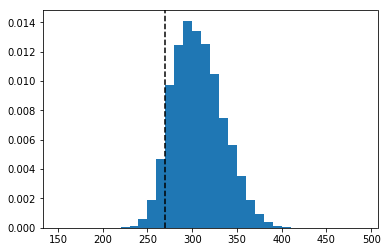

In [25]:
# Your answer here
plot_results(simulate_election_midwest_error(100000, 4))